-Importing everything I might need


In [5]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from pydataset import data

import acquire
import prepare


- Acquiring the dataset

In [6]:
df = acquire.get_titanic_data()

- Checking to see if the acquire was successful

In [7]:
df.head()

,Unnamed: 0,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


- Making my function to do an initial 'cleanse' of the data

In [8]:
def prep_titanic(df):
    '''This function takes in the titanic df specifically and drops the 
    listed columns and creates dummy variables for the selected columns'''
    
    drop_cols = ['Unnamed: 0', 'passenger_id', 'embarked', 'class', 'deck']
    
    df.drop(columns = drop_cols, inplace = True)
    
    dummies = pd.get_dummies(df[['sex', 'embark_town']], drop_first = True)

    df = pd.concat([df, dummies], axis = 1)
    
    df.drop(columns = ['sex', 'embark_town'], inplace = True)
    
    df.rename(columns = {'embark_town_Queenstown': 'embark_Q', 'embark_town_Southampton': 'embark_S'}, inplace = True)
    
    return df


- Running my dataframe through my cleanse function by calling it

In [9]:
df = prep_titanic(df)

- Checking to see if my data 'cleanse' is what I wanted

In [10]:
df.head()

,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_Q,embark_S
0,0,3,22.0,1,0,7.2500,0,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,1,0,1


- Dropping some additional columns that I don't believe are useful at this point

In [12]:
df.drop(columns = ['fare', 'embark_Q', 'embark_S'], inplace = True)

- Dropping the age column as I found out it has too many nulls, I did not impute them because there were too many

In [ ]:
df.drop(columns = 'age', inplace = True)

- Creating a function here that will split my data

In [22]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

- Calling the function here to split my data

In [23]:
# split into train, validate, test
train, validate, test = train_validate_test_split(df, target='survived', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['survived'])
y_train = train.survived

X_validate = validate.drop(columns=['survived'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

- Creating the knn variable to assign how may neighbors will be calculated to determine the value of the introduced object

In [54]:
knn = KNeighborsClassifier(n_neighbors = 20, weights='uniform')

- Fitting the knn variable to my model

In [55]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

- Calculating the score of my validate section of my data

In [56]:
knn.score(X_validate, y_validate)

0.7616822429906542

- Creating the prediction variable that will be run through the algorithm

In [57]:
y_pred = knn.predict(X_train)

- Creating the variable for the probability of the prediciton variable we just created

In [58]:
y_pred_proba = knn.predict_proba(X_train)

- Calling the accuracy score of the train portion of the dataset

In [59]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.80


- Printing the confusion matrix that gives me my true and false positive and negative counts based on my predictions

In [60]:
print(confusion_matrix(y_train, y_pred))

[[264  43]
 [ 57 134]]


- Printing my classification report to see my results

In [61]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       307
           1       0.76      0.70      0.73       191

    accuracy                           0.80       498
   macro avg       0.79      0.78      0.78       498
weighted avg       0.80      0.80      0.80       498



- Printing the accuracy score of the validate portion of the dataset

In [62]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on test set: 0.76


- Creating a visual of the model

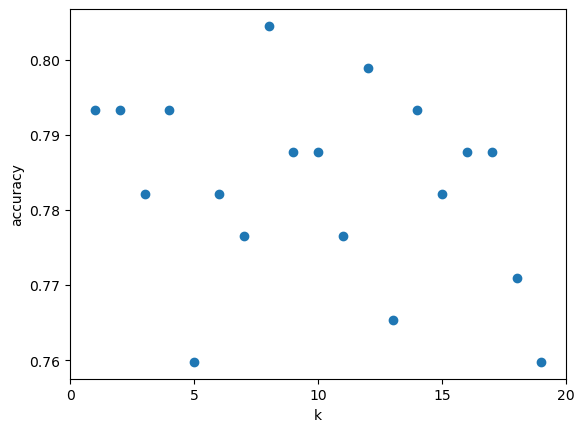

In [63]:
import matplotlib.pyplot as plt
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

- Assigning the TP, FP, TN, FN variables for k5

In [49]:
tp_k5 = 270
tn_k5 = 141
fp_k5 = 37
fn_k5 = 50

- Calculating and printing the rates for my confusion matrix

In [50]:
print("True positive rate is:", tp_k5 / (tp_k5 + fn_k5))
print("True negative rate is:", tn_k5 / (fp_k5 + tn_k5))
print("False positive rate is:", fp_k5/ (fp_k5 + tn_k5))
print("False Negative rate is:", fn_k5 / (fn_k5 + tp_k5))

True positive rate is: 0.84375
True negative rate is: 0.7921348314606742
False positive rate is: 0.20786516853932585
False Negative rate is: 0.15625


- Assigning the TP, FP, TN, FN variables for k10

In [52]:
tp_k10 = 278
tn_k10 = 127
fp_k10 = 29
fn_k10 = 64

In [53]:
print("True positive rate is:", tp_k10 / (tp_k10 + fn_k10))
print("True negative rate is:", tn_k10 / (fp_k10 + tn_k10))
print("False positive rate is:", fp_k10/ (fp_k10 + tn_k10))
print("False Negative rate is:", fn_k10 / (fn_k10 + tp_k10))

True positive rate is: 0.8128654970760234
True negative rate is: 0.8141025641025641
False positive rate is: 0.1858974358974359
False Negative rate is: 0.1871345029239766


In [64]:
tp_k20 = 264
tn_k20 = 134
fp_k20 = 43
fn_k20 = 57

In [65]:
print("True positive rate is:", tp_k20 / (tp_k10 + fn_k20))
print("True negative rate is:", tn_k20 / (fp_k10 + tn_k20))
print("False positive rate is:", fp_k20 / (fp_k10 + tn_k20))
print("False Negative rate is:", fn_k20 / (fn_k10 + tp_k20))

True positive rate is: 0.7880597014925373
True negative rate is: 0.8220858895705522
False positive rate is: 0.26380368098159507
False Negative rate is: 0.17378048780487804
